In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black
%matplotlib inline

By default the application assumes that the catalog is collocated with the data as shown below.  Assuming that is the
case an environment variable can be set and the application will find the data.

```bash
ls /mnt/data/sevir/
CATALOG.csv  data
```

In [2]:
import os

os.environ["PATH_TO_SEVIR"] = "/mnt/data/sevir"  # you can set the default path via an environment variable

# Constants

There is a constants module with several of the SEVIR dataset constants.
The image types are a subclass of a string enum with some extra attribute metadata.

In [3]:
import enum
import random

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sevirs
from sevirs.constants import VIS, IR_069, VIL, IR_107, LGHT, ImageInfo, ImageType

assert isinstance(VIS, str)
assert isinstance(VIS, ImageInfo)
assert isinstance(VIS, ImageType)
assert isinstance(VIS, enum.Enum)

# the enum is hashable and can be used as a dictionary key or in a dataframe
data = {VIS: 1}

print(
    "The ImageType is a subclass of a string so it can be accessed via it's string value",
    [data, data["vis"], data[VIS], VIS == "vis"],  # type: ignore
    "\nThe additional metadata is available as attributes.",
    [VIS, VIS.value, VIS.description, VIS.sensor, VIS.patch_size, VIS.time_steps],
    "\nAccessing an ImageType by it's string value is also possible.",
    [sevirs.ImageType(t) for t in ["vis", "ir069", "ir107", "vil", "lght"]],
    "\nThe ImageType class is an enumeration so it is iterable.",
    list(sevirs.ImageType),
    "\nThey share the same hash so in a `set`...",
    f"{set(['vis', sevirs.ImageType.VIS]) = }",
    sep="\n",
)
assert (
    "vis"
    == VIS
    == sevirs.ImageType("vis")
    == sevirs.ImageType(VIS)
    == sevirs.ImageType("VIS")
    == sevirs.ImageType["VIS"]
    == sevirs.ImageType.VIS
)

The ImageType is a subclass of a string so it can be accessed via it's string value
[{ImageType.VIS: 1}, 1, 1, True]

The additional metadata is available as attributes.
[ImageType.VIS, 'vis', 'Visible satellite imagery', 'GOES-16 C02 0.64', 768, 5]

Accessing an ImageType by it's string value is also possible.
[ImageType.VIS, ImageType.IR_069, ImageType.IR_107, ImageType.VIL, ImageType.LGHT]

The ImageType class is an enumeration so it is iterable.
[ImageType.VIS, ImageType.IR_069, ImageType.IR_107, ImageType.VIL, ImageType.LGHT]

They share the same hash so in a `set`...
set(['vis', sevirs.ImageType.VIS]) = {'vis'}


## Catalog

The catalog is a wrapper around the a polars dataframe. The underlying `Dataframe` can be accessed via the `data` property.
and can be instantiated from the path to the sevir dataset/catalog or from a `Dataframe`.


In [4]:
cat = sevirs.Catalog("/mnt/data/sevir")
cat = sevirs.Catalog("/mnt/data/sevir/CATALOG.csv", drop_duplicates=False)
assert isinstance(cat, sevirs.Catalog)
assert isinstance(sevirs.Catalog(cat), sevirs.Catalog)
assert isinstance(sevirs.Catalog(cat.data), sevirs.Catalog)
assert isinstance(sevirs.Catalog(cat.data.to_pandas()), sevirs.Catalog)


def my_filter(self: sevirs.Catalog) -> pl.DataFrame:
    mask = self.id == "R18032505027684"
    return self.data.filter(mask)


assert isinstance(cat(my_filter), sevirs.Catalog)
print(cat.shape)
cat[cat.id == "R18032505027684"].data.head()

(63829, 22)


id,file_name,file_index,img_type,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing,file_ref
str,str,i64,str,datetime[μs],str,f64,f64,str,f64,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,null
"""R1803250502768…","""/mnt/data/sevi…",0,"""vis""",2018-03-25 05:00:00,"""-120:-115:-110…",null,null,null,33.216708,-91.635132,36.336627,-87.070254,"""+proj=laea +la…",768,768,384000.0,384000.0,-0.003361,0.0056,0.0,null
"""R1803250502768…","""/mnt/data/sevi…",82,"""vis""",2018-03-25 05:00:00,"""-120:-115:-110…",null,null,null,33.182653,-92.54195,36.340467,-88.015706,"""+proj=laea +la…",768,768,384000.0,384000.0,-0.003361,0.0056,0.0,null
"""R1803250502768…","""/mnt/data/sevi…",504,"""ir107""",2018-03-25 05:00:00,"""-120:-115:-110…",null,null,null,33.182653,-92.54195,36.340467,-88.015706,"""+proj=laea +la…",192,192,384000.0,384000.0,-49.568752,15.690057,0.0,null
"""R1803250502768…","""/mnt/data/sevi…",506,"""ir107""",2018-03-25 05:00:00,"""-120:-115:-110…",null,null,null,33.216708,-91.635132,36.336627,-87.070254,"""+proj=laea +la…",192,192,384000.0,384000.0,-52.48761,15.613359,0.0,null
"""R1803250502768…","""/mnt/data/sevi…",496,"""ir069""",2018-03-25 05:00:00,"""-120:-115:-110…",null,null,null,33.182653,-92.54195,36.340467,-88.015706,"""+proj=laea +la…",192,192,384000.0,384000.0,-59.289093,-15.741784,0.0,null


In [5]:
# there are some duplicated (img_ids, img_type) but they are unique to the bounding box
# and the file index. This is something to just keep in consideration.
print(
    len(cat.data),
    len(cat.data.filter(cat.data[["id", "img_type"]].is_duplicated())),
    len(cat.data.filter(cat.data[["id", "img_type", "time_utc"]].is_duplicated())),
    len(
        cat.data.filter(
            cat.data[["id", "img_type", "llcrnrlat", "llcrnrlon", "urcrnrlat", "urcrnrlon"]].is_duplicated()
        )
    ),
    len(cat.data.filter(cat.data[["id", "img_type", "file_index"]].is_duplicated())),
    len(cat.data.groupby(["id", "img_type"]).first()[["id", "img_type"]].is_duplicated()),
)


def drop_duplicates(df: pl.DataFrame, subset: list[str]) -> pl.DataFrame:
    return df.groupby(subset).first()

63829 572 572 0 0 63543


In [6]:
cat.data.filter((cat.data["id"] == "R18032505027684") & (cat["img_type"] == "vil"))

id,file_name,file_index,img_type,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing,file_ref
str,str,i64,str,datetime[μs],str,f64,f64,str,f64,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,null
"""R1803250502768…","""/mnt/data/sevi…",1173,"""vil""",2018-03-25 05:02:30,"""-120:-115:-110…",null,null,null,33.182653,-92.54195,36.340467,-88.015706,"""+proj=laea +la…",384,384,384000.0,384000.0,0.0,219.0,0.546938,null
"""R1803250502768…","""/mnt/data/sevi…",1175,"""vil""",2018-03-25 05:02:30,"""-120:-115:-110…",null,null,null,33.216708,-91.635132,36.336627,-87.070254,"""+proj=laea +la…",384,384,384000.0,384000.0,0.0,219.0,0.546938,null


In [7]:
x, y = cat(my_filter).intersect(
    (sevirs.ImageType.IR_069, sevirs.ImageType.IR_107),
    (sevirs.ImageType.VIS, sevirs.ImageType.VIL),
)
print(x, y, sep="\n")

[Catalog]
shape: (4, 22)
┌────────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ id         ┆ file_name ┆ file_inde ┆ img_type ┆ … ┆ data_min  ┆ data_max  ┆ pct_missi ┆ file_ref │
│ ---        ┆ ---       ┆ x         ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ng        ┆ ---      │
│ str        ┆ str       ┆ ---       ┆ str      ┆   ┆ f64       ┆ f64       ┆ ---       ┆ null     │
│            ┆           ┆ i64       ┆          ┆   ┆           ┆           ┆ f64       ┆          │
╞════════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ R180325050 ┆ /mnt/data ┆ 504       ┆ ir107    ┆ … ┆ -49.56875 ┆ 15.690057 ┆ 0.0       ┆ null     │
│ 27684      ┆ /sevir/da ┆           ┆          ┆   ┆ 2         ┆           ┆           ┆          │
│            ┆ ta/ir107/ ┆           ┆          ┆   ┆           ┆           ┆           ┆          │
│            ┆ 2018/…    ┆           ┆          ┆   ┆           ┆ 

In [8]:
VIS_VIL = VIS, VIL
try:
    # attempting a create a catalog with duplicate image types will raise a ValueError
    sevirs.Catalog(img_types=(VIS, VIS, VIL))
    assert False
except ValueError:
    print("ValueError: Image types must be unique.")
    cat = sevirs.Catalog(img_types=VIS_VIL)

# the types are based on the image types provided to the catalog
# and should maintain the same order
assert cat.types is VIS_VIL
print(cat.types)
cat.data.head()

ValueError: Image types must be unique.
(ImageType.VIS, ImageType.VIL)


id,img_type,file_name,file_index,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing,file_ref
str,str,str,i64,datetime[μs],str,f64,f64,str,f64,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,null
"""R1803221610741…","""vis""","""/mnt/data/sevi…",19,2018-03-22 16:10:00,"""-120:-115:-110…",null,null,null,36.966651,-122.209326,41.11562,-118.938469,"""+proj=laea +la…",768,768,384000.0,384000.0,0.001508,1.014334,0.0,null
"""R1803241255762…","""vis""","""/mnt/data/sevi…",25,2018-03-24 12:55:00,"""-120:-115:-110…",null,null,null,32.740219,-84.98829,35.572614,-80.19751,"""+proj=laea +la…",768,768,384000.0,384000.0,-0.003241,0.813576,0.0,null
"""R1803241255787…","""vis""","""/mnt/data/sevi…",28,2018-03-24 12:55:00,"""-120:-115:-110…",null,null,null,36.235076,-86.578031,39.119786,-81.592717,"""+proj=laea +la…",768,768,384000.0,384000.0,-0.003038,0.9121,0.0,null
"""R1803292140802…","""vis""","""/mnt/data/sevi…",41,2018-03-29 21:40:00,"""-120:-115:-110…",null,null,null,38.170781,-87.582419,41.091798,-82.483181,"""+proj=laea +la…",768,768,384000.0,384000.0,0.010456,0.913215,0.0,null
"""R1803290320814…","""vis""","""/mnt/data/sevi…",50,2018-03-29 03:20:00,"""-120:-115:-110…",null,null,null,44.20859,-110.827547,48.051171,-106.529101,"""+proj=laea +la…",768,768,384000.0,384000.0,-0.003216,0.202898,0.0,null


## H5 Store

Once the catalog is created it can be passed to the H5Store to open all of the files.

In [9]:
# Loading the catalog into the store to open all of the files
# and provided a indexable interface to the data.
h5 = sevirs.Store(cat)

# The Store mapping interface will return a list of arrays based on the order
# of image_types provided to the Catalog constructor.
assert h5.types == cat.types == VIS_VIL

# The store copies the catalog and resets the reference column.
assert cat is not h5.catalog and cat.data is not h5.data
assert not np.all(cat.data == h5.data)

# The catalog and h5 store share have the same columns and share a abstract
# catalog interface.
assert cat.data.shape == h5.data.shape
assert set(cat.columns) == set(h5.columns)
assert all(cat.file_name == h5.file_name)
print(
    f"""
[cat.file_ref]
{cat.file_ref.dtype}
[h5.file_ref]
{h5.file_ref.dtype}"""
)

INFO:root:Loading 93 files with 2 image types.
100%|██████████| 93/93 [00:02<00:00, 31.27it/s]


[cat.file_ref]
Null
[h5.file_ref]
Int32


In [10]:
id_ = random.choice(h5.id)
print(f"random id: {id_}")

# because the h5 store was initialized with a catalog containing 2 image types, they are both spit out
print(h5.types)
vis, vil = h5[id_]
print(f"vis: {vis.shape}, vil: {vil.shape}")

random id: R18070518537484
(ImageType.VIS, ImageType.VIL)
vis: (768, 768, 49), vil: (384, 384, 49)


In [11]:
(vis2,), df = h5.select(id_, img_types=[VIS], metadata=True)
assert np.all(vis == vis2)
print(f"vis: {vis2.shape}")

vis: (768, 768, 49)


In [12]:
assert len(h5) == len(h5._files) == h5.catalog.file_ref.n_unique() > 0
print(
    f"""
# the size of the catalog is the number of unique file names
{len(h5)=}
{len(h5._files)=}
{len(h5.data)=}
{h5.file_ref.n_unique()=}
{h5.file_name.n_unique()=}
#
{h5.img_type.n_unique()=}
#
{len(h5.catalog)=}
{len(h5.catalog.data)=}
{h5.catalog.shape=}
"""
)

pd.Series({col: h5.catalog[col].n_unique() for col in h5.catalog.columns}).sort_values()


# the size of the catalog is the number of unique file names
len(h5)=93
len(h5._files)=93
len(h5.data)=25602
h5.file_ref.n_unique()=93
h5.file_name.n_unique()=93
#
h5.img_type.n_unique()=2
#
len(h5.catalog)=25602
len(h5.catalog.data)=25602
h5.catalog.shape=(25602, 22)



proj                  1
height_m              1
width_m               1
img_type              2
size_x                2
size_y                2
event_type            9
file_name            93
file_ref             93
minute_offsets      152
pct_missing         979
file_index         2367
episode_id         2381
event_id           2565
time_utc           5029
data_max          10878
data_min          11167
id                12826
llcrnrlon         13255
llcrnrlat         15187
urcrnrlon         16564
urcrnrlat         16869
dtype: int64

In [13]:
assert len(h5) != 0 and not h5.is_closed()
h5.close()
assert len(h5) == 0 and h5.is_closed()

In [14]:
# The store also provides class method to load the catalog directly from disk.
# And a context manager to ensure the store is closed after use.
with sevirs.Store.from_disk() as h5:
    assert not h5.is_closed()
assert h5.is_closed()

INFO:root:Loading 132 files with 5 image types.
100%|██████████| 132/132 [00:02<00:00, 56.94it/s]


INFO:root:Loading 132 files with 5 image types.
100%|██████████| 132/132 [00:01<00:00, 81.02it/s]


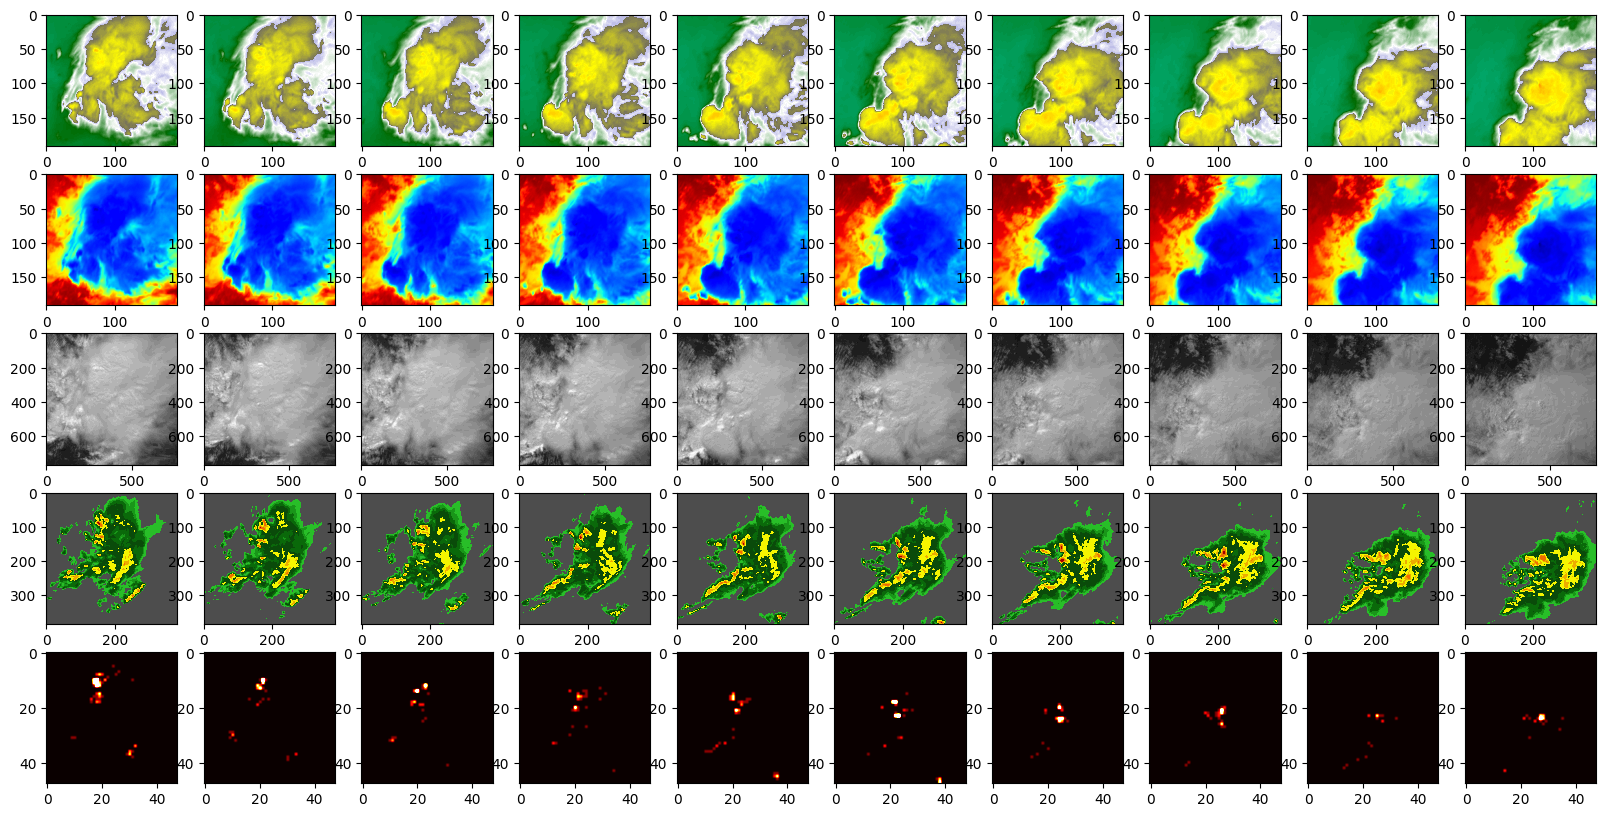

In [15]:
img_types = IR_069, IR_107, VIS, VIL, LGHT


with sevirs.Store.from_disk(img_types=img_types) as h5:
    ir069, ir107, vis, vil, lght = h5.select("S858968")

time_step = 10  # n time steps


fig, axs, indices = sevirs.plot.timegrid(
    time_step,  # num time-steps along x axis
    vil.shape[-1],  # total time-steps
    len(img_types),  # num img-types along y axis
    ratio=2,
)


for x, y in indices:
    axs[0, x].imshow(ir069[:, :, y], **sevirs.plot.with_kwargs(IR_069, encoded=True))
    axs[1, x].imshow(ir107[:, :, y], **sevirs.plot.with_kwargs(IR_107, encoded=True))
    axs[2, x].imshow(vis[:, :, y], **sevirs.plot.with_kwargs(VIS, encoded=True))
    axs[3, x].imshow(vil[:, :, y], **sevirs.plot.with_kwargs(VIL, encoded=True))
    axs[4, x].imshow(lght[:, :, y], **sevirs.plot.with_kwargs(LGHT, encoded=True))

# interpolating the LxW grid so the arrays are the same shape

INFO:root:Loading 112 files with 3 image types.
100%|██████████| 112/112 [00:01<00:00, 78.01it/s]


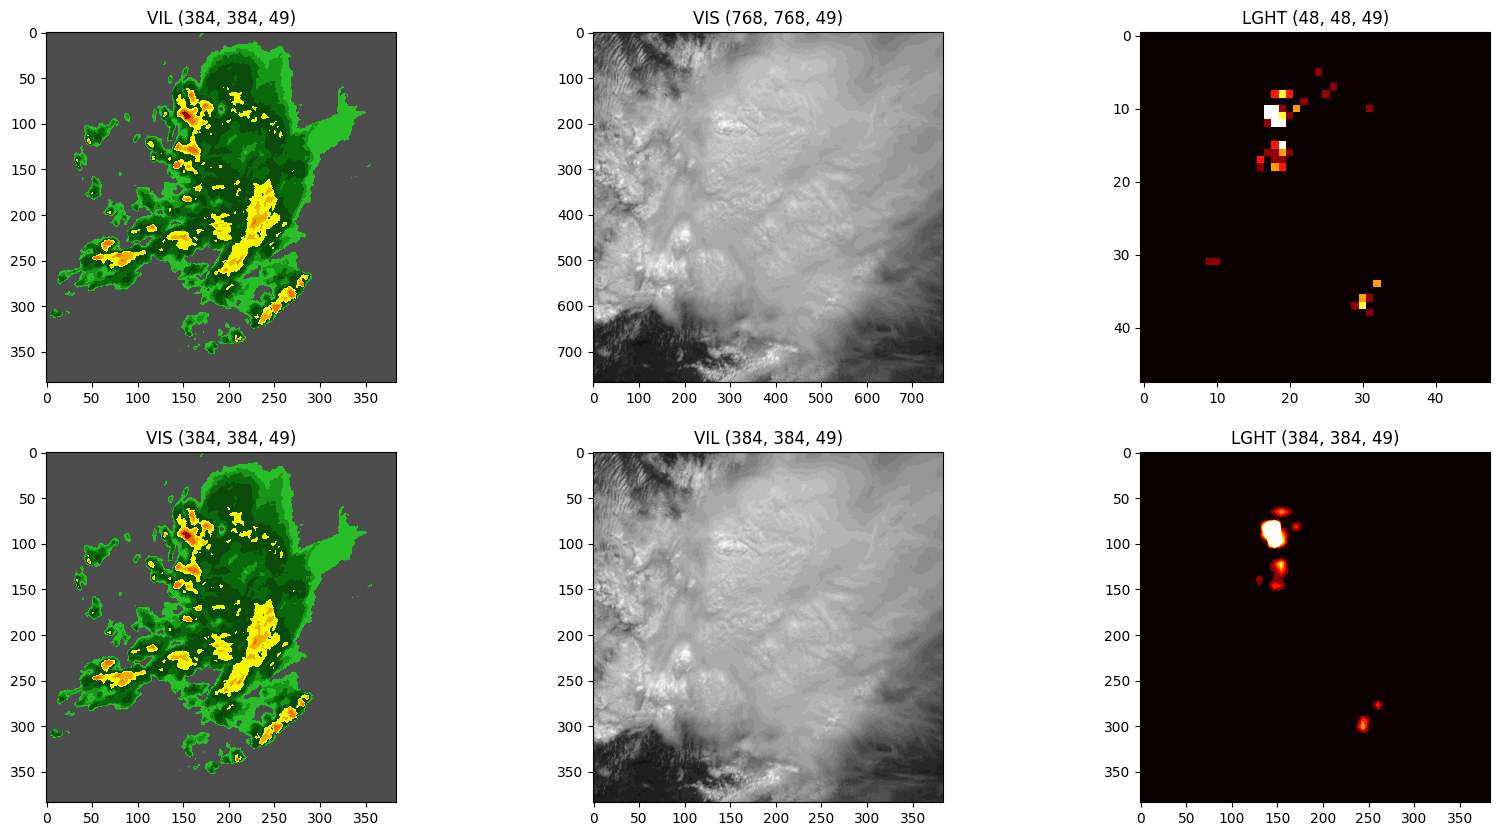

In [16]:
import sevirs.core.h5

with sevirs.Store(sevirs.Catalog("/mnt/data/sevir", img_types=(VIS, VIL, LGHT))) as h5:
    vis1, vil1, lght1 = h5.select("S858968", img_types=(VIS, VIL, LGHT))  # list[(Height, Width, Time), ...]
    patch_size = max(vil1.shape[:2])
    # interpolate all of the images_types for the selected ID
    # to the provided patch size and stack them with a new dimension for the channel
    stack1 = h5.interp("S858968", patch_size=patch_size)  # (Channel, Height, Width, Time)


vis2 = sevirs.core.h5.interpatch(vis1, patch_size=patch_size)
vil2 = sevirs.core.h5.interpatch(vil1, patch_size=patch_size)
lght2 = sevirs.core.h5.interpatch(lght1, patch_size=patch_size)

# the original image are not the same shape in the (x, y) dimensions
assert vis1.shape != vil1.shape != lght1.shape
# by interpolating the patch size all the image are the same shape
assert vis2.shape == vil2.shape == lght2.shape


fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0, 0].set_title(f"VIL {vil1.shape}")
ax[0, 0].imshow(vil1[:, :, 0], **sevirs.plot.with_kwargs(VIL, encoded=True))

ax[0, 1].set_title(f"VIS {vis1.shape}")
ax[0, 1].imshow(vis1[:, :, 0], **sevirs.plot.with_kwargs(VIS, encoded=True))

ax[0, 2].set_title(f"LGHT {lght1.shape}")
ax[0, 2].imshow(lght1[:, :, 0], **sevirs.plot.with_kwargs(LGHT, encoded=True))

ax[1, 0].set_title(f"VIS {vil2.shape}")
ax[1, 0].imshow(vil2[:, :, 0], **sevirs.plot.with_kwargs(VIL, encoded=True))

ax[1, 1].set_title(f"VIL {vis2.shape}")
ax[1, 1].imshow(vis2[:, :, 0], **sevirs.plot.with_kwargs(VIS, encoded=True))

ax[1, 2].set_title(f"LGHT {lght2.shape}")
ax[1, 2].imshow(lght2[:, :, 0], **sevirs.plot.with_kwargs(LGHT, encoded=True))

In [17]:
%timeit np.concatenate([vis2[np.newaxis], vil2[np.newaxis], lght2[np.newaxis]], axis=0)
%timeit np.stack([vis2, vil2, lght2], axis=0)
stack2 = np.stack([vis2, vil2, lght2], axis=0)
stack3 = np.concatenate([vis2[np.newaxis], vil2[np.newaxis], lght2[np.newaxis]], axis=0)

assert np.all(stack1 == stack2) and np.all(stack2 == stack3) and np.all(stack1 == stack3)
print(
    stack1.shape,
    stack2.shape,
    stack3.shape,
    "(Channel, Height, Width, Time)",
)

6.08 ms ± 544 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.68 ms ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(3, 384, 384, 49) (3, 384, 384, 49) (3, 384, 384, 49) (Channel, Height, Width, Time)


# Plotting and animating with cartopy

INFO:root:Loading 81 files with 1 image types.
100%|██████████| 81/81 [00:02<00:00, 32.23it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 16.666666666666668 -loop 0 rgba:- -layers OptimizePlus assets/S858968-vis.gif


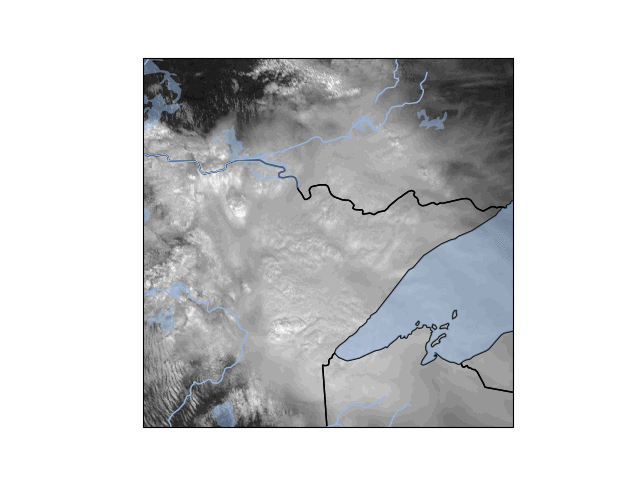

In [19]:
from IPython.core.display import Image

out_file = "assets/S858968-vis.gif"
with sevirs.Store(sevirs.Catalog(img_types=(VIS,))) as h5:
    (arr,), df = h5.select("S858968", metadata=True)
anim = sevirs.plot.animation(arr, df, img_type=VIS)
anim.save(out_file, writer="imagemagick", fps=6)

plt.close()  # close the figure to prevent it from being displayed inline
h5.close()  # the store
Image(out_file)  # display the gif

# FeatureGenerator, TimeSeriesGenerator, TensorLoader

The generator will use the default catalog or a filtered catalog can be provided.
to instantiate the generator. Specify a `patch_size` to upsample/downsample the images.

Channels are the inputs or features in that order.

```python
inputs = (IR_069, IR_107, VIS)
targets = (VIL,)
with sevirs.FeatureGenerator(inputs=inputs, targets=targets) as tg:
    x, y = next(iter(tg))
    vis = x[inputs.index(VIS), :, :, :] # VIS channel
    ((ir069, ir107, vis), (vil,)) = next(iter(tg))
```

In [ ]:
import torch

PATCH_SIZE = 128  # the patch size for images to be interpolated to

with sevirs.FeatureGenerator(
    "/mnt/data/sevir", inputs=(IR_069, IR_107, VIS), targets=(VIL,), patch_size=PATCH_SIZE
) as fg:
    (x, y), df = fg.select("R19082620197425", metadata=True)
    print("torch.Size([C,   Y,   X,  T])", x.shape, y.shape, sep="\n")


tensors = [
    x[0, :, : PATCH_SIZE // 2, 0] * 0.02,
    y[0, :, PATCH_SIZE // 2 :, 0],
]
plt.imshow(torch.concat(tensors, dim=1))
plt.title(f"{IR_069} | {VIL}")
plt.show()

In [ ]:
BATCH_SIZE = 15  # the number of batches for the loader to stack

with sevirs.TensorLoader(
    sevirs.FeatureGenerator("/mnt/data/sevir", inputs=(VIS, IR_069, IR_107), targets=(VIL,), patch_size=PATCH_SIZE),
    batch_size=BATCH_SIZE,
) as tl:
    x, y = next(iter(tl))
    print("torch.Size([ B, C,   Y,   X,  T])", x.shape, y.shape, sep="\n")

In [ ]:
with sevirs.TensorLoader(
    sevirs.TimeSeriesGenerator(
        "/mnt/data/sevir", img_types=(VIS, IR_069, IR_107), patch_size=PATCH_SIZE, n_inputs=12, n_targets=5
    ),
    batch_size=BATCH_SIZE,
) as loader:
    x, y = next(iter(loader))
    print("torch.Size([ B, C,   Y,   X,  T])", x.shape, y.shape, sep="\n")